In [1]:
import numpy as np
import xarray as xr
import pandas as pd

## extract data for relevant region

original data is what download from ERA5 Land
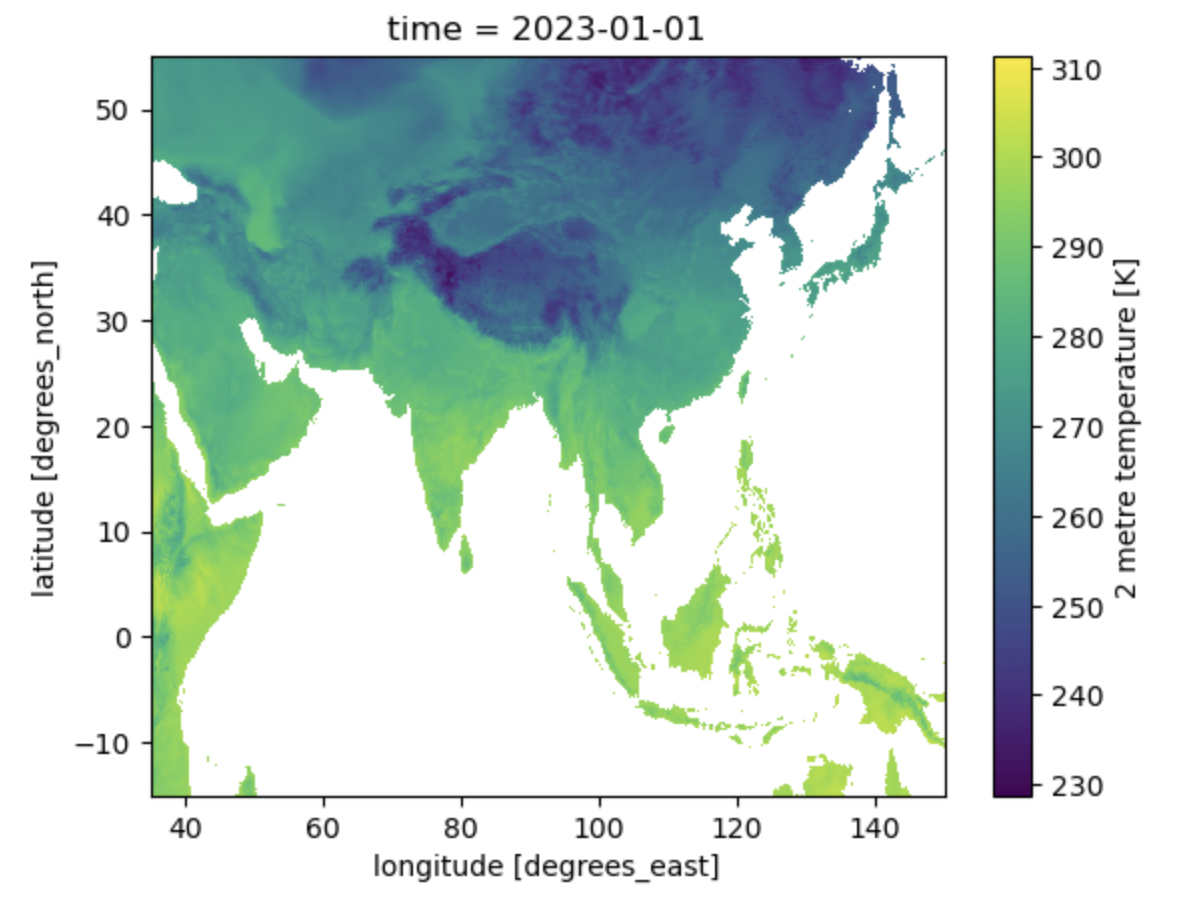

it is just for reducing file size: use xarray sel
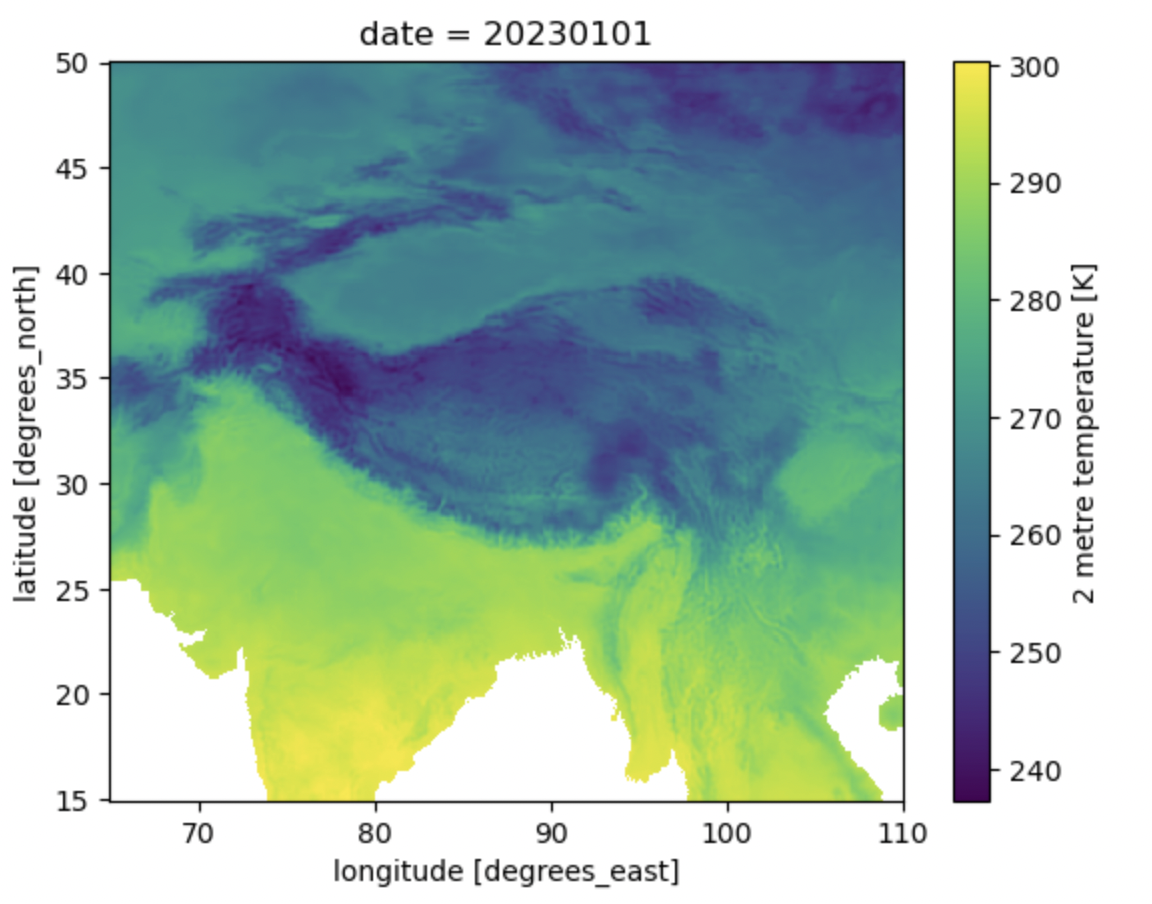

get only daily mean: xarray groupby

write to data/tb.nc

Techniques needed:

- __*xarray groupby*__ and take statistics
- __*xarray sel*__: indecing technique in xarray



In [2]:

if 0: # if is just to easily comment out the processs 
    ds = xr.open_dataset('/Users/doan/Desktop/2023_2t_era5_land.nc')
    tb = ds.sel(longitude = slice(65,110), latitude = slice(50,15) )
    tb0 = tb.groupby('time.date').mean() 

    times = pd.to_datetime(tb0.date.values).strftime('%Y%m%d')

    tb0.date.values[:]  = times # just want to change the format of date (not matter much this time)

    tb0.to_netcdf('data/tb.nc')
    # check plot
    #ds.t2m[0].plot()
    #tb0.t2m[0].plot() 

## Make low- and high-res data and put is together

this is just reference code, one can do it flexibly


 

In [3]:


if 1:
    
    ds = xr.open_dataset('data/tb.nc', engine='netcdf4')['t2m']
    print('shape of original data: ', ds.shape)
    
    # get "high-resolution data"
    # because the original data is at too high-resolution, here we reduce it (just for convenient purpose)
    n_int = 7
    # https://docs.xarray.dev/en/latest/user-guide/interpolation.html
    d1 = ds.interp(latitude=ds.latitude[::n_int], longitude = ds.longitude[::n_int])
    
    
    print('shape of interpolated data: ', d1.shape)
    
    n_blur = 7
    # rolling https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html
    d2 = d1.rolling( {'latitude':n_blur,'longitude':n_blur}, center=True).mean()
    
    print('shape of rolling data: ', d2.shape)
    
    
    d4 = d2[:, ::n_blur,::n_blur]
    
    print('shape of rolling data: ', d4.shape)
    
    d5 = d4.interp(latitude=d1.latitude, longitude = d1.longitude, method= 'nearest')
    
    # extract only Tibet area using .sel
    do = xr.Dataset( {'hi': d1, 'lo':d5} ).sel(longitude = slice(75,97.25), latitude = slice(42.75,26) )
    
    print(do)
    do.to_netcdf('data/tb_input.nc')

shape of original data:  (365, 351, 451)
shape of interpolated data:  (365, 51, 65)
shape of rolling data:  (365, 51, 65)
shape of rolling data:  (365, 8, 10)
<xarray.Dataset>
Dimensions:    (date: 365, latitude: 24, longitude: 32)
Coordinates:
  * date       (date) object '20230101' '20230102' ... '20231230' '20231231'
  * latitude   (latitude) float32 42.3 41.6 40.9 40.2 ... 28.3 27.6 26.9 26.2
  * longitude  (longitude) float32 75.5 76.2 76.9 77.6 ... 95.1 95.8 96.5 97.2
Data variables:
    hi         (date, latitude, longitude) float32 261.5 270.0 ... 272.3 272.3
    lo         (date, latitude, longitude) float32 257.0 257.0 ... 272.3 272.3


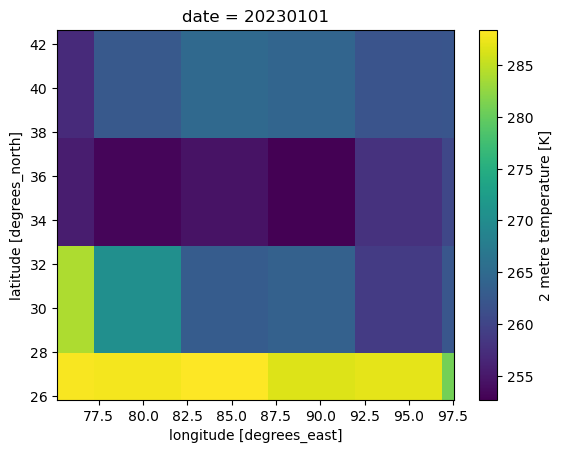

In [4]:
do['lo'][0].plot()

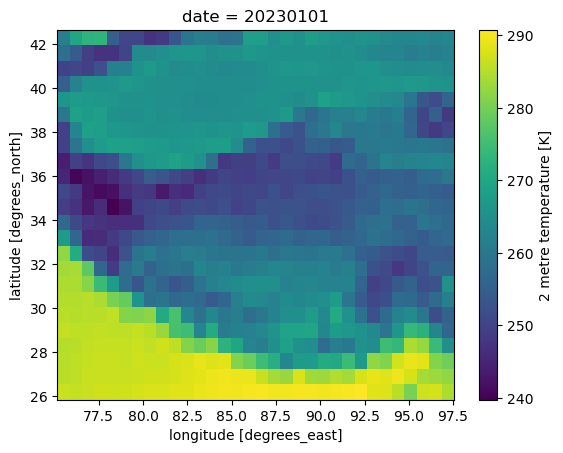

In [5]:
do['hi'][0].plot()

## Divide data into three sets
- training
- validating
- testing

Here random selection is used.

70% of data is used for training

60% of remaining 30% is used for validation

40% of remaining 30% is used for testing

__there is no any rules how to divide, this is just a showcase__

__data is then writen into three seperate files__


### techniques used

> random
> 
> numpy .setdiff1d
>
> numpy .unique
>
> numpy .union1d
>
> xarray .isel (different with .sel)

In [6]:
dinput = xr.open_dataset('data/tb_input.nc')

we have  365 sample


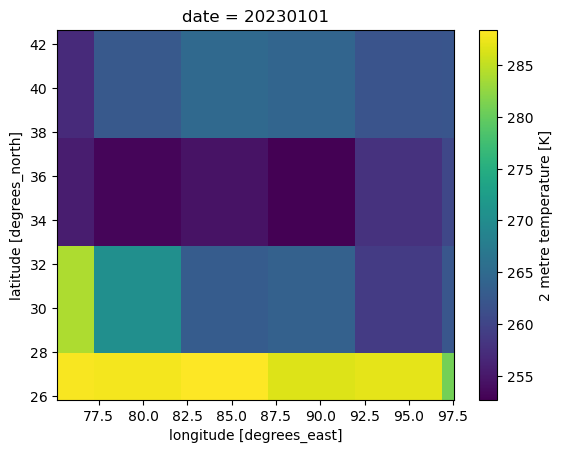

In [7]:
dinput.lo[0].plot()
#n = 365
n = dinput['hi'].shape[0]
print('we have ', n, 'sample')

In [8]:
# separate data to three part: 1) training; 2) validation; 3) test
ii = np.arange(n)
n_train = int(round(.7*n))
print('extract: ', n_train, 'for training')

extract:  255 for training


In [9]:
import random
itrain=[]
while len(itrain) !=  n_train :
   r=random.randint(0,n-1)
   if r not in itrain: itrain.append(r)

In [10]:
print( 'check len of training data: ', len(np.unique(itrain)), len(itrain))
print('get 70% of whole data to train: ', len(itrain))

check len of training data:  255 255
get 70% of whole data to train:  255


In [11]:
i2 = np.setdiff1d(ii, itrain)
print('then we have remaining ', len(i2))

then we have remaining  110


In [12]:
n_vt = len(i2)
n_val = int(round(.6*n_vt))

In [13]:
j1=[]
while len(j1) !=  n_val :
    r=random.randint(0, n_vt - 1)
    if r not in j1: j1.append(r)

In [14]:
ival = i2[j1]
itest = np.setdiff1d(i2, ival)

In [15]:
print(np.unique(np.union1d(itrain, np.union1d(ival, itest))).shape)
print(len(itrain) + len(ival) + len(itest))
# -

(365,)
365


In [17]:
dtrain0 = dinput.isel(date=itrain)
dval0 = dinput.isel(date=ival)
dtest0 = dinput.isel(date=itest)


# =====
dtrain0.to_netcdf('data/tb_train.nc')
dval0.to_netcdf('data/tb_val.nc')
dtest0.to_netcdf('data/tb_test.nc')













